<a href="https://colab.research.google.com/github/ravindranaithani/week3.ipynb/blob/main/MLP_Week_4_LinearRegressionDemo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear Regression for house price prediction
In this colab, we will build different linear regression models for california house price prediction:

1. Linear regression (with normal equation and iterative optimization)
2. Polynomial regression
3. Regularized regression models - ridge and lasso.

We will set regularization rate and polynomial degree with hyper-parameter tuning and cross validation.

We will compare different models in terms of their parameter vectors and mean absolute error on train, devel and test sets.

# Imports

For regression problem, we need to import classes and utilities from `sklearn.linear_model`.  
*  This module has implementations for different regression models like `LinearRegression`, `SGDRegressor`, `Ridge`, `Lasso`, `RidgeCV`, and `LassoCV`.  

We also need to import a bunch of model selection utilities from `sklearn.model_selection` module and metrics from `sklearn.metrics` module.

The data preprocessing utilities are imported from `sklearn.preprocessing` modules.



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import loguniform
from scipy.stats import uniform

from sklearn.datasets import fetch_california_housing
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Common set up

Set up random seed to a number of your choice.

In [ ]:
np.random.seed(306)

Let's use `ShuffleSplit` as cv with 10 splits and 20% examples set aside as test examples.

In [ ]:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

# Data Loading and splitting

We use california housing dataset for this demo.  We will load this dataset with `fetch_california_housing` API as a dataframe.

We will load the data and split it into three parts - train, dev and test.  Train+Dev will be used for cross validation and test will be used for evaluating the trained models.

In [ ]:
# fetch dataset
features, labels = fetch_california_housing(as_frame=True, return_X_y=True)

# train-test split
com_train_features, test_features, com_train_labels, test_labels = train_test_split(
    features, labels, random_state=42)

# train --> train + dev split
train_features, dev_features, train_labels, dev_labels = train_test_split(
    com_train_features, com_train_labels, random_state=42)

In [ ]:
?ShuffleSplit()

# Linear regression with normal equation

Let's use normal equation method to train linear regression model.

We set up pipeline with two stages:
* Feature scaling to scale features and
* Linear regression on the transformed feature matrix.

Throughout this colab, we will have the following pattern for each estimator:
* We will be using `Pipeline` for combining data preprocessing and modeling steps.
* `cross_validate` for training the model with `ShuffleSplit` cross validation and `neg_mean_absolute_error` as a scoring metric.
*  Convert the scores to error and report mean absolute errors on the dev set.


In [ ]:
lin_reg_pipeline = Pipeline([("feature_scaling", StandardScaler()),
                             ("lin_reg", LinearRegression())])
lin_reg_cv_results = cross_validate(lin_reg_pipeline,
                                    com_train_features,
                                    com_train_labels,
                                    cv=cv,
                                    scoring="neg_mean_absolute_error",
                                    return_train_score=True,
                                    return_estimator=True)

lin_reg_train_error = -1 * lin_reg_cv_results['train_score']
lin_reg_test_error = -1 * lin_reg_cv_results['test_score']

print(f"Mean absolute error of linear regression model on the train set:\n"
      f"{lin_reg_train_error.mean():.3f} +/- {lin_reg_train_error.std():.3f}")
print(f"Mean absolute error of linear regression model on the test set:\n"
      f"{lin_reg_test_error.mean():.3f} +/- {lin_reg_test_error.std():.3f}")

Mean absolute error of linear regression model on the train set:
0.530 +/- 0.002
Mean absolute error of linear regression model on the test set:
0.527 +/- 0.008


Both the errors are close, but are not low.  This points to underfitting.  We can address it by adding more feature through polynomial regression.

# Linear regression with SGD

Let's use iterative optimization method to train linear regression model.

We set up pipeline with two stages:
* Feature scaling to scale features and
* SGD regression on the transformed feature matrix.


In [ ]:
sgd_reg_pipeline = Pipeline([("feature_scaling", StandardScaler()),
                             ("sgd_reg", SGDRegressor(
                                 max_iter=np.ceil(
                                    1e6/com_train_features.shape[0]),
                                 early_stopping=True,
                                 eta0=1e-4,
                                 learning_rate='constant',
                                 tol=1e-5,
                                 validation_fraction=0.1,
                                 n_iter_no_change=5,
                                 average=10,
                                 random_state=42))])

sgd_reg_cv_results = cross_validate(sgd_reg_pipeline,
                                    com_train_features,
                                    com_train_labels,
                                    cv=cv,
                                    scoring="neg_mean_absolute_error",
                                    return_train_score=True,
                                    return_estimator=True)

sgd_train_error = -1 * sgd_reg_cv_results['train_score']
sgd_test_error = -1 * sgd_reg_cv_results['test_score']

print(f"Mean absolute error of SGD regression model on the train set:\n"
      f"{sgd_train_error.mean():.3f} +/- {sgd_train_error.std():.3f}")
print(f"Mean absolute error of SGD regression model on the test set:\n"
      f"{sgd_test_error.mean():.3f} +/- {sgd_test_error.std():.3f}")

ValueError: ignored

# Polynomial regression

We will train a polynomial model with degree 2 and later we will use `validation_curve` to find out right degree to use for polynomial models.

`PolynomialFeatures` transforms the features to the user specified degrees (here it is 2).  We perform feature scaling on the transformed features before using them for training the regression model.

In [ ]:
poly_reg_pipeline = Pipeline([("poly", PolynomialFeatures(degree=2)),
                              ("feature_scaling", StandardScaler()),
                              ("lin_reg", LinearRegression())])
poly_reg_cv_results = cross_validate(poly_reg_pipeline,
                                    com_train_features,
                                    com_train_labels,
                                    cv=cv,
                                    scoring="neg_mean_absolute_error",
                                    return_train_score=True,
                                    return_estimator=True)

poly_reg_train_error = -1 * poly_reg_cv_results['train_score']
poly_reg_test_error = -1 * poly_reg_cv_results['test_score']

print(f"Mean absolute error of linear regression model on the train set:\n"
      f"{poly_reg_train_error.mean():.3f} +/- {poly_reg_train_error.std():.3f}")
print(f"Mean absolute error of linear regression model on the test set:\n"
      f"{poly_reg_test_error.mean():.3f} +/- {poly_reg_test_error.std():.3f}")

Mean absolute error of linear regression model on the train set:
0.461 +/- 0.003
Mean absolute error of linear regression model on the test set:
0.485 +/- 0.030


Notice that the training and validation errors have reduced after using the second order polynomial features to represent the model.

Instead of using all polynomial feature, we use only interaction feature terms in polynomial model and train the linear regression model.

In [ ]:
poly_reg_pipeline = Pipeline([("poly", PolynomialFeatures(degree=2, interaction_only=True)),
                              ("feature_scaling", StandardScaler()),
                              ("lin_reg", LinearRegression())])
poly_reg_cv_results = cross_validate(poly_reg_pipeline,
                                    com_train_features,
                                    com_train_labels,
                                    cv=cv,
                                    scoring="neg_mean_absolute_error",
                                    return_train_score=True,
                                    return_estimator=True)

poly_reg_train_error = -1 * poly_reg_cv_results['train_score']
poly_reg_test_error = -1 * poly_reg_cv_results['test_score']

print(f"Mean absolute error of polynomial regression model of degree 2 on the train set:\n"
      f"{poly_reg_train_error.mean():.3f} +/- {poly_reg_train_error.std():.3f}")
print(f"Mean absolute error of polynomial regression model of degree 2 on the test set:\n"
      f"{poly_reg_test_error.mean():.3f} +/- {poly_reg_test_error.std():.3f}")

Mean absolute error of polynomial regression model of degree 2 on the train set:
0.478 +/- 0.003
Mean absolute error of polynomial regression model of degree 2 on the test set:
0.497 +/- 0.024


Let's figure out which degree polynomial is better suited for the regression problem at our hand. For that we will use `validation_curve`, which can be considered as a manual hyperparameter tuning.

Here we specify a list of values that we want to try for polynomial degree and specify it as a parameter in `validation_curve`.

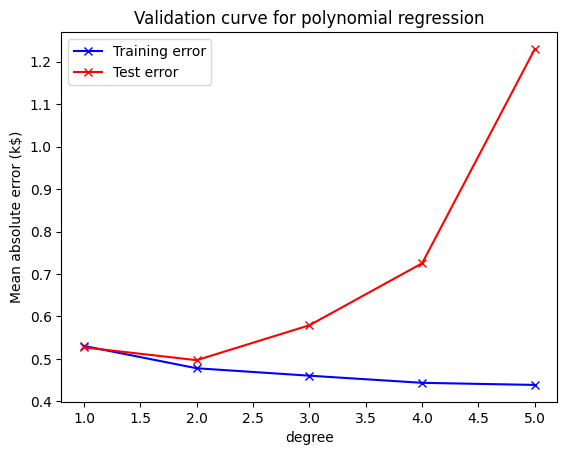

In [ ]:
degree = [1, 2, 3, 4, 5]
train_scores, test_scores = validation_curve(
    poly_reg_pipeline, com_train_features, com_train_labels, param_name="poly__degree",
    param_range=degree, cv=cv, scoring="neg_mean_absolute_error",
    n_jobs=2)

train_errors, test_errors = -train_scores, -test_scores
plt.plot(degree, train_errors.mean(axis=1), 'b-x', label="Training error")
plt.plot(degree, test_errors.mean(axis=1), 'r-x', label="Test error")
plt.legend()

plt.xlabel("degree")
plt.ylabel("Mean absolute error (k$)")
_ = plt.title("Validation curve for polynomial regression")

We would select a degree for which the mean absolute error is the least.  In this case, it is degree=2 that yields the least mean absolute error and that would be selected as an optimal degree for polynomial regression.

# Ridge regression

The polynomial models have a tendency to overfit - if we use higher order polynomial features. We will use `Ridge` regression - which penalizes for excessive model complexity in the polynomial regression by adding a regularization term.  Here we specify the regularization rate `alpha` as 0.5 and train the regression model.  Later we will launch hyperparameter search for the right value of `alpha` such that it leads to the least cross validation errors.

In [ ]:
ridge_reg_pipeline = Pipeline([("poly", PolynomialFeatures(degree=2)),
                              ("feature_scaling", StandardScaler()),
                              ("ridge", Ridge(alpha=0.5))])
ridge_reg_cv_results = cross_validate(ridge_reg_pipeline,
                                    com_train_features,
                                    com_train_labels,
                                    cv=cv,
                                    scoring="neg_mean_absolute_error",
                                    return_train_score=True,
                                    return_estimator=True)

ridge_reg_train_error = -1 * ridge_reg_cv_results['train_score']
ridge_reg_test_error = -1 * ridge_reg_cv_results['test_score']

print(f"Mean absolute error of ridge regression model (alpha=0.5) on the train set:\n"
      f"{ridge_reg_train_error.mean():.3f} +/- {ridge_reg_train_error.std():.3f}")
print(f"Mean absolute error of ridge regression model (alpha=0.5) on the test set:\n"
      f"{ridge_reg_test_error.mean():.3f} +/- {ridge_reg_test_error.std():.3f}")

Mean absolute error of ridge regression model (alpha=0.5) on the train set:
0.481 +/- 0.003
Mean absolute error of ridge regression model (alpha=0.5) on the test set:
0.487 +/- 0.006


# HPT for ridge regularization rate

In [ ]:
alpha_list = np.logspace(-4, 0, num=20)
ridge_reg_pipeline = Pipeline([("poly", PolynomialFeatures(degree=2)),
                              ("feature_scaling", StandardScaler()),
                              ("ridge_cv", RidgeCV(alphas=alpha_list,
                                                   cv=cv,
                                                   scoring="neg_mean_absolute_error"))])
ridge_reg_cv_results = ridge_reg_pipeline.fit(com_train_features, com_train_labels)

In [ ]:
print ("The score with the best alpha is:",
       f"{ridge_reg_cv_results[-1].best_score_:.3f}")
print ("The error with the best alpha is:",
       f"{-ridge_reg_cv_results[-1].best_score_:.3f}")

The score with the best alpha is: -0.473
The error with the best alpha is: 0.473


In [ ]:
print ("The best value for alpha:", ridge_reg_cv_results[-1].alpha_)

The best value for alpha: 0.007847599703514606


## `RidgeCV` with cross validation

Let's search for right value of regularization rate through `RidgeCV`, where we specify the regularization rates to be tried.

In [ ]:
alpha_list = np.logspace(-4, 0, num=20)
ridge_reg_pipeline = Pipeline([("poly", PolynomialFeatures(degree=2)),
                              ("feature_scaling", StandardScaler()),
                              ("ridge_cv", RidgeCV(alphas=alpha_list,
                                                   store_cv_values=True))])
ridge_reg_cv_results = cross_validate(ridge_reg_pipeline,
                                    com_train_features,
                                    com_train_labels,
                                    cv=cv,
                                    scoring="neg_mean_absolute_error",
                                    return_train_score=True,
                                    return_estimator=True)

ridge_reg_train_error = -1 * ridge_reg_cv_results['train_score']
ridge_reg_test_error = -1 * ridge_reg_cv_results['test_score']

print(f"Mean absolute error of ridge regression model on the train set:\n"
      f"{ridge_reg_train_error.mean():.3f} +/- {ridge_reg_train_error.std():.3f}")
print(f"Mean absolute error of ridge regression model on the test set:\n"
      f"{ridge_reg_test_error.mean():.3f} +/- {ridge_reg_test_error.std():.3f}")

Mean absolute error of ridge regression model on the train set:
0.470 +/- 0.011
Mean absolute error of ridge regression model on the test set:
0.474 +/- 0.011


Let's look at the mean of mean absolute errors at different values of regularization rate across different cross validation folds.

In [ ]:
mse_alphas = [est[-1].cv_values_.mean(axis=0)
              for est in ridge_reg_cv_results["estimator"]]
cv_alphas = pd.DataFrame(mse_alphas, columns=alpha_list)
cv_alphas

,0.000100,0.000162,0.000264,0.000428,0.000695,0.001129,0.001833,0.002976,0.004833,0.007848,0.012743,0.020691,0.033598,0.054556,0.088587,0.143845,0.233572,0.379269,0.615848,1.000000
0,79.825105,83.556979,89.052274,96.713331,106.577419,117.958587,129.309233,138.553544,143.696595,143.239843,136.323827,122.943609,104.328753,82.970054,61.840053,43.298869,28.559398,17.803633,10.526486,5.909713
1,14.065799,13.742714,13.245802,12.504952,11.450787,10.048351,8.345884,6.505474,4.765508,3.333758,2.295126,1.610844,1.183945,0.919624,0.750990,0.641272,0.577008,0.556458,0.575055,0.616682
2,5.267710,5.272331,5.279626,5.290956,5.308105,5.333104,5.367714,5.412616,5.466685,5.526801,5.588436,5.647108,5.700570,5.751087,5.806722,5.879665,5.978467,6.094229,6.190664,6.210415
3,5.853085,5.867043,5.888945,5.922643,5.972982,6.045051,6.142429,6.264704,6.405584,6.553176,6.692444,6.808469,6.889793,6.931979,6.940661,6.931633,6.923902,6.924670,6.915607,6.852967
4,8.134646,7.993974,7.781172,7.471108,7.042443,6.489075,5.830605,5.110992,4.379774,3.666586,2.970194,2.275449,1.595598,1.021163,0.731173,0.912456,1.609059,2.646320,3.729320,4.609697
5,66.100008,60.047159,52.002193,42.279138,31.879141,22.232981,14.513912,9.100108,5.651189,3.553748,2.267632,1.438728,0.884846,0.552525,0.464962,0.651161,1.080903,1.657819,2.268932,2.827886
6,2.309882,2.253722,2.168544,2.044094,1.871808,1.650275,1.391207,1.120910,0.873056,0.675781,0.543603,0.482411,0.504610,0.643451,0.952959,1.480223,2.215475,3.063332,3.875894,4.520391
7,19.019937,20.494095,22.742542,26.033396,30.548208,36.182667,42.368884,48.126041,52.384040,54.327657,53.538865,50.004599,44.134732,36.750467,28.898463,21.529074,15.270441,10.392246,6.862006,4.445108
8,4.351827,4.345297,4.335085,4.319448,4.296236,4.263277,4.219299,4.165380,4.106281,4.050251,4.006641,3.983150,3.985501,4.019862,4.095335,4.222623,4.405521,4.627181,4.842507,4.987779
9,3.963850,3.952362,3.934504,3.907436,3.867958,3.813571,3.744526,3.666285,3.590431,3.532157,3.505531,3.520803,3.586362,3.713344,3.917635,4.213494,4.596544,5.025147,5.419899,5.688782


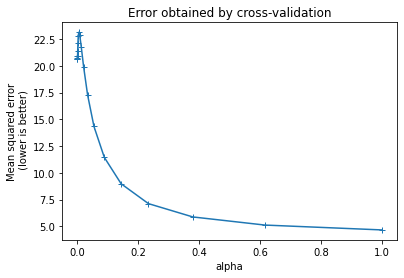

In [ ]:
cv_alphas.mean(axis=0).plot(marker="+")
plt.ylabel("Mean squared error\n (lower is better)")
plt.xlabel("alpha")
_ = plt.title("Error obtained by cross-validation")

In [ ]:
best_alphas = [est[-1].alpha_ for est in ridge_reg_cv_results["estimator"]]
best_alphas

[1.0,
 0.3792690190732246,
 0.0001,
 0.0001,
 0.08858667904100823,
 0.08858667904100823,
 0.0206913808111479,
 1.0,
 0.0206913808111479,
 0.012742749857031334]

The optimal regularization strength is not necessarily the same on all cross-validation iterations. But since we expect each cross-validation resampling to stem from the same data distribution, it is common practice to use the average value of the best alpha found on different cross-validation folds as our final estimate for the tuned alpha.

In [ ]:
print(f"The mean optimal alpha leading to the best generalization performance is:\n"
      f"{np.mean(best_alphas):.2f} +/- {np.std(best_alphas):.2f}")

The mean optimal alpha leading to the best generalization performance is:
0.26 +/- 0.38




## Ridge HPT through `GridSearchCV`

In [ ]:
ridge_grid_pipeline = Pipeline([("poly", PolynomialFeatures(degree=2)),
                              ("feature_scaling", StandardScaler()),
                              ("ridge", Ridge())])

param_grid = {'poly__degree': (1, 2, 3),
              'ridge__alpha': np.logspace(-4, 0, num=20)}
ridge_grid_search = GridSearchCV(ridge_grid_pipeline,
                                 param_grid=param_grid,
                                 n_jobs=2,
                                 cv=cv,
                                 scoring="neg_mean_absolute_error",
                                 return_train_score=True)
ridge_grid_search.fit(com_train_features, com_train_labels)

GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=42, test_size=0.2, train_size=None),
             estimator=Pipeline(steps=[('poly', PolynomialFeatures()),
                                       ('feature_scaling', StandardScaler()),
                                       ('ridge', Ridge())]),
             n_jobs=2,
             param_grid={'poly__degree': (1, 2, 3),
                         'ridge__alpha': array([1.00000000e-04, 1.62377674e-04, 2.63665090e-04, 4.28133240e-04,
       6.95192796e-04, 1.12883789e-03, 1.83298071e-03, 2.97635144e-03,
       4.83293024e-03, 7.84759970e-03, 1.27427499e-02, 2.06913808e-02,
       3.35981829e-02, 5.45559478e-02, 8.85866790e-02, 1.43844989e-01,
       2.33572147e-01, 3.79269019e-01, 6.15848211e-01, 1.00000000e+00])},
             return_train_score=True, scoring='neg_mean_absolute_error')

`ridge_grid_search.best_index_` gives us the index of the best parameter in the list.

In [ ]:
mean_train_error = -1 * ridge_grid_search.cv_results_['mean_train_score'][ridge_grid_search.best_index_]
mean_test_error = -1 * ridge_grid_search.cv_results_['mean_test_score'][ridge_grid_search.best_index_]
std_train_error = ridge_grid_search.cv_results_['std_train_score'][ridge_grid_search.best_index_]
std_test_error = ridge_grid_search.cv_results_['std_train_score'][ridge_grid_search.best_index_]

print(f"Best Mean absolute error of polynomial ridge regression model on the train set:\n"
      f"{mean_train_error:.3f} +/- {std_train_error:.3f}")
print(f"Mean absolute error of polynomial ridge regression model on the test set:\n"
      f"{mean_test_error:.3f} +/- {std_test_error:.3f}")

Best Mean absolute error of polynomial ridge regression model on the train set:
0.463 +/- 0.004
Mean absolute error of polynomial ridge regression model on the test set:
0.474 +/- 0.004


In [ ]:
print ("Mean cross validated score of the best estimator is: ", ridge_grid_search.best_score_)
print ("Mean cross validated error of the best estimator is: ", -ridge_grid_search.best_score_)

Mean cross validated score of the best estimator is:  -0.47386511769919126
Mean cross validated error of the best estimator is:  0.47386511769919126


Note that this is same as `RidgeCV` that we carried out earlier.

In [ ]:
print ("The best parameter value is:", ridge_grid_search.best_params_)

The best parameter value is: {'poly__degree': 2, 'ridge__alpha': 0.007847599703514606}


# Lasso regression

## Baseline model with fixed learning rate

In [ ]:
lasso_reg_pipeline = Pipeline([("poly", PolynomialFeatures(degree=2)),
                              ("feature_scaling", StandardScaler()),
                              ("lasso", Lasso(alpha=0.01))])
lasso_reg_cv_results = cross_validate(lasso_reg_pipeline,
                                    com_train_features,
                                    com_train_labels,
                                    cv=cv,
                                    scoring="neg_mean_absolute_error",
                                    return_train_score=True,
                                    return_estimator=True)

lasso_reg_train_error = -1 * lasso_reg_cv_results['train_score']
lasso_reg_test_error = -1 * lasso_reg_cv_results['test_score']

print(f"Mean absolute error of linear regression model on the train set:\n"
      f"{lasso_reg_train_error.mean():.3f} +/- {ridge_reg_train_error.std():.3f}")
print(f"Mean absolute error of linear regression model on the test set:\n"
      f"{lasso_reg_test_error.mean():.3f} +/- {ridge_reg_test_error.std():.3f}")

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.986e+01, tolerance: 1.654e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.109e+01, tolerance: 1.669e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.849e+01, tolerance: 1.658e

Mean absolute error of linear regression model on the train set:
0.529 +/- 0.011
Mean absolute error of linear regression model on the test set:
0.528 +/- 0.011


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.255e+01, tolerance: 1.658e+00
  model = cd_fast.enet_coordinate_descent(


# HPT for lasso regularization rate

## With cross validation

In [ ]:
alpha_list = np.logspace(-6, 0, num=20)
lasso_reg_pipeline = Pipeline([("poly", PolynomialFeatures(degree=2)),
                              ("feature_scaling", StandardScaler()),
                              ("lasso_cv", LassoCV(alphas=alpha_list, cv=cv))])
lasso_reg_cv_results = cross_validate(lasso_reg_pipeline,
                                    com_train_features,
                                    com_train_labels,
                                    cv=cv,
                                    scoring="neg_mean_absolute_error",
                                    return_train_score=True,
                                    return_estimator=True)

lasso_reg_train_error = -1 * lasso_reg_cv_results['train_score']
lasso_reg_test_error = -1 * lasso_reg_cv_results['test_score']

print(f"Mean absolute error of linear regression model on the train set:\n"
      f"{lasso_reg_train_error.mean():.3f} +/- {lasso_reg_train_error.std():.3f}")
print(f"Mean absolute error of linear regression model on the test set:\n"
      f"{lasso_reg_test_error.mean():.3f} +/- {lasso_reg_test_error.std():.3f}")

In [ ]:
best_alphas = [est[-1].alpha_ for est in lasso_reg_cv_results["estimator"]]
best_alphas

[0.012742749857031322,
 0.012742749857031322,
 0.00615848211066026,
 0.00615848211066026,
 0.00615848211066026,
 1e-06,
 0.012742749857031322,
 0.0003359818286283781,
 0.00615848211066026,
 0.026366508987303555]

In [ ]:
print(f"The mean optimal alpha leading to the best generalization performance is:\n"
      f"{np.mean(best_alphas):.2f} +/- {np.std(best_alphas):.2f}")

The mean optimal alpha leading to the best generalization performance is:
0.01 +/- 0.01


In [ ]:
lasso_reg_pipeline = Pipeline([("poly", PolynomialFeatures(degree=2)),
                              ("feature_scaling", StandardScaler()),
                              ("lasso", Lasso(alpha=0.01))])
lasso_reg_pipeline.fit(com_train_features, com_train_labels)
train_error = mean_absolute_error(com_train_labels,
                                 lasso_reg_pipeline.predict(com_train_features))

print(f"Mean absolute error of Lasso CV model on the train set:", train_error)

Mean absolute error of Lasso CV model on the train set: 0.5291330037868303


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.759e+01, tolerance: 2.066e+00
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


## with `GridSearchCV`

In [ ]:
lasso_grid_pipeline = Pipeline([("poly", PolynomialFeatures()),
                              ("feature_scaling", StandardScaler()),
                              ("lasso", Lasso())])

param_grid = {'poly__degree': (1, 2, 3),
              'lasso__alpha': np.logspace(-4, 0, num=20)}
lasso_grid_search = GridSearchCV(lasso_grid_pipeline,
                                 param_grid=param_grid,
                                 n_jobs=2,
                                 cv=cv,
                                 scoring="neg_mean_absolute_error",
                                 return_train_score=True)
lasso_grid_search.fit(com_train_features, com_train_labels)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.638e+03, tolerance: 2.066e+00
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=42, test_size=0.2, train_size=None),
             estimator=Pipeline(steps=[('poly', PolynomialFeatures()),
                                       ('feature_scaling', StandardScaler()),
                                       ('lasso', Lasso())]),
             n_jobs=2,
             param_grid={'lasso__alpha': array([1.00000000e-04, 1.62377674e-04, 2.63665090e-04, 4.28133240e-04,
       6.95192796e-04, 1.12883789e-03, 1.83298071e-03, 2.97635144e-03,
       4.83293024e-03, 7.84759970e-03, 1.27427499e-02, 2.06913808e-02,
       3.35981829e-02, 5.45559478e-02, 8.85866790e-02, 1.43844989e-01,
       2.33572147e-01, 3.79269019e-01, 6.15848211e-01, 1.00000000e+00]),
                         'poly__degree': (1, 2, 3)},
             return_train_score=True, scoring='neg_mean_absolute_error')

In [ ]:
mean_train_error = -1 * lasso_grid_search.cv_results_['mean_train_score'][lasso_grid_search.best_index_]
mean_test_error = -1 * lasso_grid_search.cv_results_['mean_test_score'][lasso_grid_search.best_index_]
std_train_error = lasso_grid_search.cv_results_['std_train_score'][lasso_grid_search.best_index_]
std_test_error = lasso_grid_search.cv_results_['std_train_score'][lasso_grid_search.best_index_]

print(f"Best Mean absolute error of polynomial ridge regression model on the train set:\n"
      f"{mean_train_error:.3f} +/- {std_train_error:.3f}")
print(f"Mean absolute error of polynomial ridge regression model on the test set:\n"
      f"{mean_test_error:.3f} +/- {std_test_error:.3f}")

Best Mean absolute error of polynomial ridge regression model on the train set:
0.462 +/- 0.003
Mean absolute error of polynomial ridge regression model on the test set:
0.488 +/- 0.003


In [ ]:
print ("Mean cross validated score of the best estimator is: ", lasso_grid_search.best_score_)

Mean cross validated score of the best estimator is:  -0.48798304453391356


In [ ]:
print ("The best parameter value is:", lasso_grid_search.best_params_)

The best parameter value is: {'lasso__alpha': 0.0001, 'poly__degree': 3}


# SGD: Regularization and HPT
We can also perform regularization with SGD. `SGDRegressor` has many hyperparameters that require careful tuning to achieve the same performance as with `LinearRegression`.

In [ ]:
poly_sgd_pipeline = Pipeline([("poly", PolynomialFeatures()),
                              ("feature_scaling", StandardScaler()),
                              ("sgd_reg", SGDRegressor(
                                 penalty='elasticnet',
                                 random_state=42))])
poly_sgd_cv_results = cross_validate(poly_sgd_pipeline,
                                    com_train_features,
                                    com_train_labels,
                                    cv=cv,
                                    scoring="neg_mean_absolute_error",
                                    return_train_score=True,
                                    return_estimator=True)

poly_sgd_train_error = -1 * poly_sgd_cv_results['train_score']
poly_sgd_test_error = -1 * poly_sgd_cv_results['test_score']

print(f"Mean absolute error of linear regression model on the train set:\n"
      f"{poly_sgd_train_error.mean():.3f} +/- {poly_sgd_train_error.std():.3f}")
print(f"Mean absolute error of linear regression model on the test set:\n"
      f"{poly_sgd_test_error.mean():.3f} +/- {poly_sgd_test_error.std():.3f}")

Mean absolute error of linear regression model on the train set:
10824283052.546 +/- 4423288211.832
Mean absolute error of linear regression model on the test set:
10946788540.250 +/- 5396536227.703


Let's search for the best set of parameters for polynomial + SGD pipeline with `RandomizedSearchCV`.

> Remember in `RandomizedSearchCV`, we need to specify distributions for hyperparameters.

In [ ]:
class uniform_int:
    """Integer valued version of the uniform distribution"""
    def __init__(self, a, b):
        self._distribution = uniform(a, b)

    def rvs(self, *args, **kwargs):
        """Random variable sample"""
        return self._distribution.rvs(*args, **kwargs).astype(int)

Let's specify `RandomizedSearchCV` set up.

In [ ]:
param_distributions = {
    'poly__degree': [1, 2, 3],
    'sgd_reg__learning_rate': ['constant', 'adaptive', 'invscaling'],
    'sgd_reg__l1_ratio': uniform(0, 1),
    'sgd_reg__eta0': loguniform(1e-5, 1),
    'sgd_reg__power_t': uniform(0, 1)
}

poly_sgd_random_search = RandomizedSearchCV(
    poly_sgd_pipeline, param_distributions=param_distributions,
    n_iter=10, cv=cv, verbose=1, scoring='neg_mean_absolute_error'
)
poly_sgd_random_search.fit(com_train_features, com_train_labels)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1507: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1507: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,


RandomizedSearchCV(cv=ShuffleSplit(n_splits=10, random_state=42, test_size=0.2, train_size=None),
                   estimator=Pipeline(steps=[('poly', PolynomialFeatures()),
                                             ('feature_scaling',
                                              StandardScaler()),
                                             ('sgd_reg',
                                              SGDRegressor(penalty='elasticnet',
                                                           random_state=42))]),
                   param_distributions={'poly__degree': [1, 2, 3],
                                        'sgd_reg__eta0': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fc4739d4a10>,
                                        'sgd_reg__l1_ratio': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fc473897e10>,
                                        'sgd_reg__learning_rate': ['constant',
                                                                   'a

The best score can be obtained as follows:

In [ ]:
poly_sgd_random_search.best_score_

-0.5282899475024619

The best set of parameters are obtained as follows:

In [ ]:
poly_sgd_random_search.best_params_

{'poly__degree': 1,
 'sgd_reg__eta0': 8.074204494282093e-05,
 'sgd_reg__l1_ratio': 0.5830694513861019,
 'sgd_reg__learning_rate': 'constant',
 'sgd_reg__power_t': 0.2575849132301107}

And the best estimator can be accessed with `best_estimator_` member variable.

# Comparison of weight vectors

Let's look at the weight vectors produced by different models.

In [ ]:
feature_names = poly_reg_cv_results["estimator"][0][0].get_feature_names_out(
    input_features=train_features.columns)
feature_names

array(['1', 'MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population',
       'AveOccup', 'Latitude', 'Longitude', 'MedInc HouseAge',
       'MedInc AveRooms', 'MedInc AveBedrms', 'MedInc Population',
       'MedInc AveOccup', 'MedInc Latitude', 'MedInc Longitude',
       'HouseAge AveRooms', 'HouseAge AveBedrms', 'HouseAge Population',
       'HouseAge AveOccup', 'HouseAge Latitude', 'HouseAge Longitude',
       'AveRooms AveBedrms', 'AveRooms Population', 'AveRooms AveOccup',
       'AveRooms Latitude', 'AveRooms Longitude', 'AveBedrms Population',
       'AveBedrms AveOccup', 'AveBedrms Latitude', 'AveBedrms Longitude',
       'Population AveOccup', 'Population Latitude',
       'Population Longitude', 'AveOccup Latitude', 'AveOccup Longitude',
       'Latitude Longitude'], dtype=object)

In [ ]:
coefs = [est[-1].coef_ for est in poly_reg_cv_results["estimator"]]
weights_polynomial_regression = pd.DataFrame(coefs, columns=feature_names)

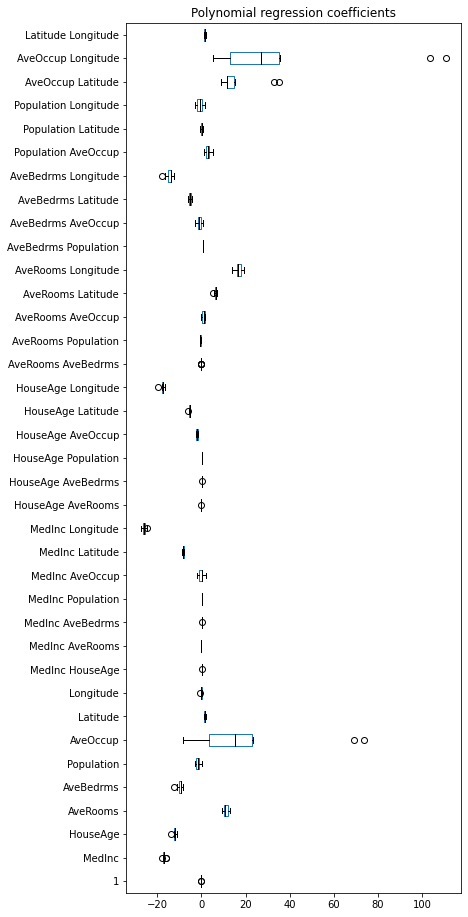

In [ ]:
color = {"whiskers": "black", "medians": "black", "caps": "black"}
weights_polynomial_regression.plot.box(color=color, vert=False, figsize=(6, 16))
_ = plt.title("Polynomial regression coefficients")

In [ ]:
feature_names = ridge_reg_cv_results["estimator"][0][0].get_feature_names_out(
    input_features=train_features.columns)
feature_names

array(['1', 'MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population',
       'AveOccup', 'Latitude', 'Longitude', 'MedInc^2', 'MedInc HouseAge',
       'MedInc AveRooms', 'MedInc AveBedrms', 'MedInc Population',
       'MedInc AveOccup', 'MedInc Latitude', 'MedInc Longitude',
       'HouseAge^2', 'HouseAge AveRooms', 'HouseAge AveBedrms',
       'HouseAge Population', 'HouseAge AveOccup', 'HouseAge Latitude',
       'HouseAge Longitude', 'AveRooms^2', 'AveRooms AveBedrms',
       'AveRooms Population', 'AveRooms AveOccup', 'AveRooms Latitude',
       'AveRooms Longitude', 'AveBedrms^2', 'AveBedrms Population',
       'AveBedrms AveOccup', 'AveBedrms Latitude', 'AveBedrms Longitude',
       'Population^2', 'Population AveOccup', 'Population Latitude',
       'Population Longitude', 'AveOccup^2', 'AveOccup Latitude',
       'AveOccup Longitude', 'Latitude^2', 'Latitude Longitude',
       'Longitude^2'], dtype=object)

In [ ]:
coefs = [est[-1].coef_ for est in ridge_reg_cv_results["estimator"]]
weights_ridge_regression = pd.DataFrame(coefs, columns=feature_names)

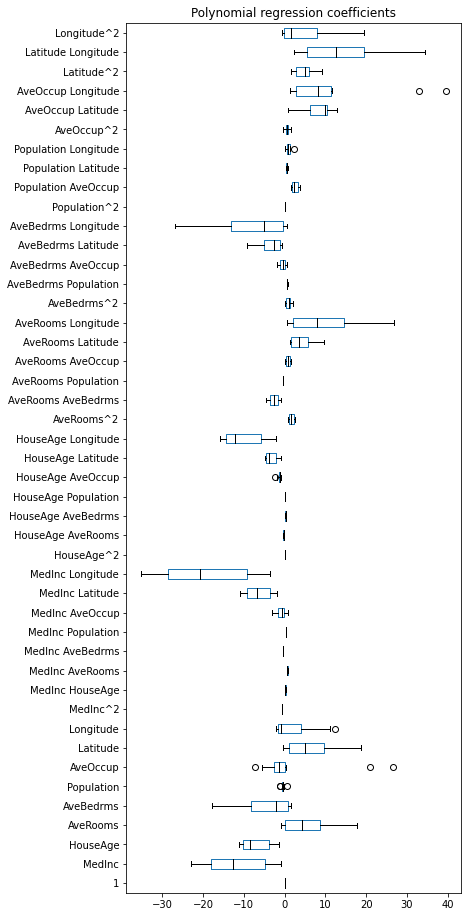

In [ ]:
color = {"whiskers": "black", "medians": "black", "caps": "black"}
weights_ridge_regression.plot.box(color=color, vert=False, figsize=(6, 16))
_ = plt.title("Polynomial regression coefficients")

# Performance on the test set

## Baseline

In [ ]:
baseline_model_median = DummyRegressor(strategy='median')
baseline_model_median.fit(train_features, train_labels)
mean_absolute_percentage_error(test_labels,
                               baseline_model_median.predict(test_features))

0.5348927548151625

## Linear regression with normal equation

In [ ]:
mean_absolute_percentage_error(test_labels,
                               lin_reg_cv_results['estimator'][0].predict(
                                   test_features))

0.32120472175482906

In [ ]:
mean_absolute_percentage_error(test_labels,
                               poly_sgd_random_search.best_estimator_.predict(
                                   test_features))

0.32020169843649454

## Polynomial regression

In [ ]:
poly_reg_pipeline.fit(com_train_features, com_train_labels)
mean_absolute_percentage_error(test_labels,
                               poly_reg_pipeline.predict(test_features))

0.28199759082657244

## Ridge regression


In [ ]:
mean_absolute_percentage_error(test_labels,
                               ridge_grid_search.best_estimator_.predict(test_features))

0.27110336451421363

## Lasso regression

Let's retrain the lasso model with `alpha` identified through hyper-parameter and evaluate it on the test data.

In [ ]:
mean_absolute_percentage_error(test_labels,
                               lasso_grid_search.best_estimator_.predict(test_features))

0.28074969263810107

# Summary

We trained multiple linear regression models on housing dataset. Set their hyperparamters through hyper-parameter optimization.  Retrained models with the best values of hyper-parameters and then evaluated their performance on the test data (that was hold back until final evaluation).  

This is how most of the real world problems are solved starting from simple models to more sophisticated models.